In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import datetime as dt
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [2]:
crypto_currency='BTC'
to_currency='USD'

training_start=dt.datetime(2016,1,1)
training_end=dt.datetime.now()

data=web.DataReader(f'{crypto_currency}-{to_currency}','yahoo',training_start,training_end)

In [3]:
scaler=MinMaxScaler()
training=scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [4]:
prediction_days = 30
future_day=1
X_train,Y_train=[],[]
for x in range(prediction_days,len(training)-future_day):
    X_train.append(training[x-prediction_days:x])
    Y_train.append(training[x+future_day])
X_train,Y_train=np.array(X_train),np.array(Y_train)
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

In [5]:
regressor = Sequential()
regressor.add(LSTM(units = 100, activation = 'sigmoid', input_shape = (None, 1),return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50,activation='sigmoid',return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50,activation='sigmoid'))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, Y_train, batch_size = 35, epochs = 100,validation_batch_size=10)

Epoch 1/100
62/62 [==============================] - 13s 73ms/step - loss: 0.1245
Epoch 2/100
62/62 [==============================] - 4s 71ms/step - loss: 0.0793
Epoch 3/100
62/62 [==============================] - 4s 71ms/step - loss: 0.0687
Epoch 4/100
62/62 [==============================] - 5s 79ms/step - loss: 0.0668
Epoch 5/100
62/62 [==============================] - 5s 78ms/step - loss: 0.0645
Epoch 6/100
62/62 [==============================] - 5s 75ms/step - loss: 0.0644
Epoch 7/100
62/62 [==============================] - 5s 74ms/step - loss: 0.0632
Epoch 8/100
62/62 [==============================] - 5s 76ms/step - loss: 0.0632
Epoch 9/100
62/62 [==============================] - 5s 76ms/step - loss: 0.0623
Epoch 10/100
62/62 [==============================] - 4s 70ms/step - loss: 0.0622
Epoch 11/100
62/62 [==============================] - 4s 71ms/step - loss: 0.0630
Epoch 12/100
62/62 [==============================] - 4s 71ms/step - loss: 0.0625
Epoch 13/100
62/62 [====

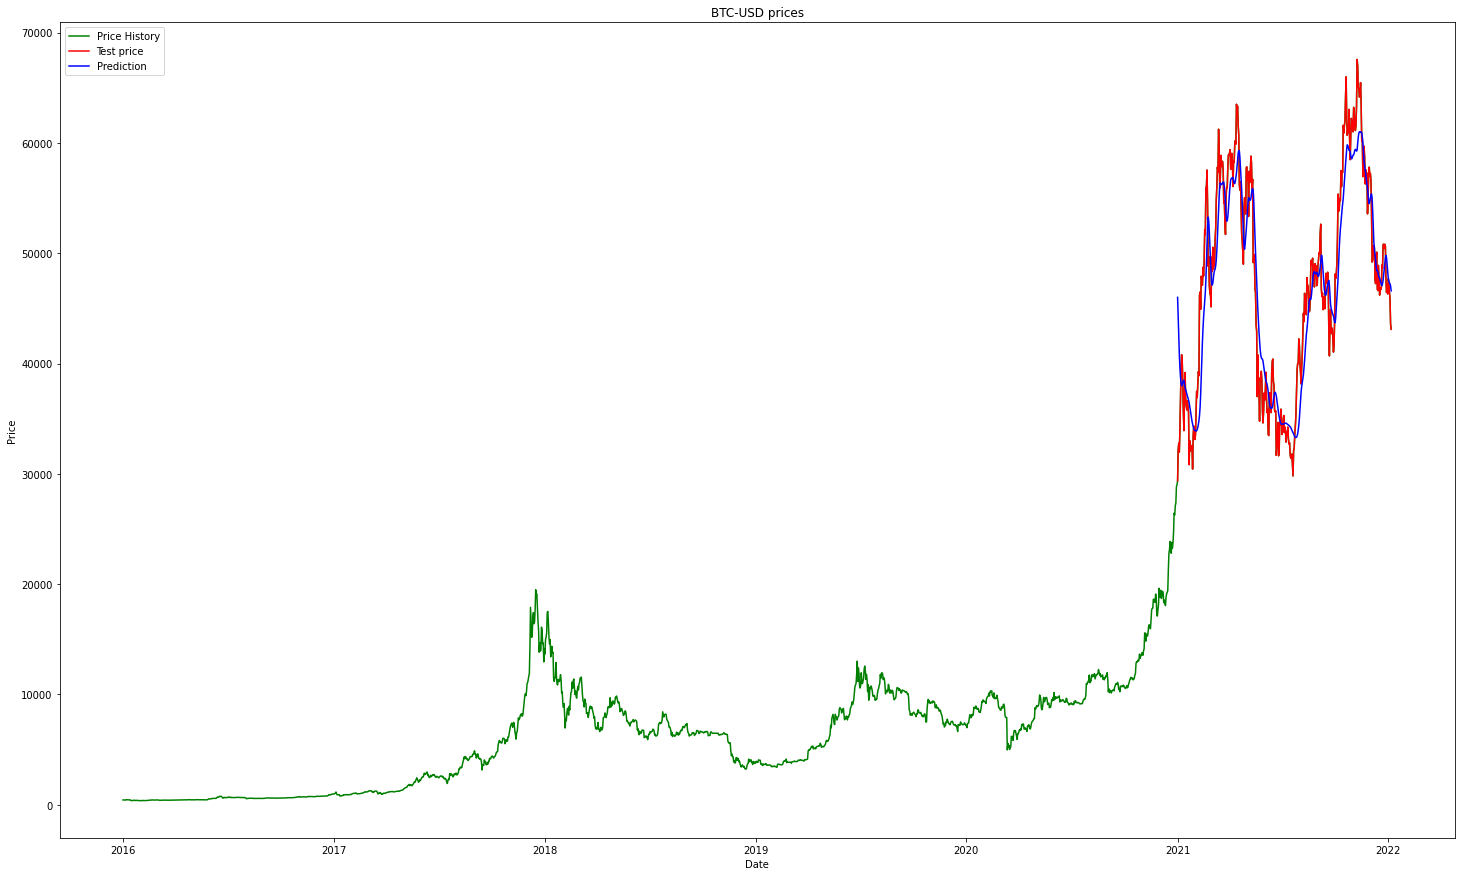

The average accuracy of the algorithm is: 93.64827070416416


In [6]:
test_start=dt.datetime(2021,1,1)
test_end=dt.datetime.now()
test_data=web.DataReader(f'{crypto_currency}-{to_currency}','yahoo',test_start,test_end)

realprice=test_data['Close'].values

full_dataset=pd.concat((data['Close'],test_data['Close']),axis=0)

inputs=full_dataset[len(full_dataset)-len(test_data)-prediction_days:].values
inputs=inputs.reshape(-1,1)
inputs=scaler.fit_transform(inputs)

X_test=[]

for x in range(prediction_days,len(inputs)):
    X_test.append(inputs[x-prediction_days:x,0])

X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1,1))

prediction_price=regressor.predict(X_test)
prediction_price = scaler.inverse_transform(prediction_price)

ndf = pd.DataFrame()
ndf['Acc'] = 1 - (abs(prediction_price.reshape(1,-1)[0] - test_data['Close'].values)/prediction_price.reshape(1,-1)[0])

x=full_dataset.index

test_data["prediction_price"]=prediction_price

plt.figure(figsize=(25,15))
plt.plot(data['Close'],color='green',label='Price History')
plt.plot(test_data['Close'],color='red',label='Test price')
plt.plot(test_data['prediction_price'],color='blue',label='Prediction')
plt.title(f'{crypto_currency}-{to_currency} prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc=2, prop={'size': 10})
plt.show()

print('The average accuracy of the algorithm is:', ndf['Acc'].mean()*100)